In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

#current_dir = pathlib.Path(os.getcwd())
#data_dir = current_dir / 'data' / 'compressed_dataset'
data_dir = pathlib.Path('/kaggle/input/geolocation-geoguessr-images-50k/compressed_dataset')

print(f"Buscando imágenes en: {data_dir}")

# Escaneamos todas las imágenes .jpg y guardamos su ruta y su país (el nombre de la carpeta)
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

df = pd.DataFrame({'Filepath': [str(x) for x in filepaths], 'Label': labels})

# Mezclamos los datos para que el modelo no aprenda países en orden
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())

Buscando imágenes en: /kaggle/input/geolocation-geoguessr-images-50k/compressed_dataset
                                            Filepath      Label
0  /kaggle/input/geolocation-geoguessr-images-50k...     France
1  /kaggle/input/geolocation-geoguessr-images-50k...  Australia
2  /kaggle/input/geolocation-geoguessr-images-50k...     France
3  /kaggle/input/geolocation-geoguessr-images-50k...     France
4  /kaggle/input/geolocation-geoguessr-images-50k...    Ukraine


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Usamos el 20% para validar
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    horizontal_flip=True # Ayuda a que aprenda que Suiza es Suiza aunque la foto esté despejada
)

# Cargamos las imágenes de entrenamiento
train_images = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Cargamos las imágenes de validación
val_images = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

2026-01-31 13:03:34.664015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769864614.859101      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769864614.916689      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769864615.367597      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769864615.367641      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769864615.367644      55 computation_placer.cc:177] computation placer alr

Found 39998 validated image filenames belonging to 124 classes.
Found 9999 validated image filenames belonging to 124 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Obtenemos el número de clases (países)
num_classes = len(train_images.class_indices)
print(f"Configurando salida para {num_classes} países.")

def crear_modelo_base():
    model = models.Sequential()

    # --- BLOQUE 1: Extracción de características de bajo nivel ---
    # Captura bordes, colores simples (cielo, asfalto)
    # Entrada: 224x224x3 (definido en tu target_size)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2))) 

    # --- BLOQUE 2: Características de nivel medio ---
    # Captura texturas (hierba, patrones de carretera)
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # --- BLOQUE 3: Características de alto nivel ---
    # Captura objetos más complejos (señales, formas de casas)
    # Aumentamos filtros a 128
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # --- BLOQUE 4: Opcional (Recomendado para Geoguessr) ---
    # El TFG usa modelos más profundos (Skin Model 2) para mejorar resultados.
    # Dado que geolocalizar es difícil, añadimos una capa extra de 128 filtros.
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # --- CLASIFICADOR (Fully Connected) ---
    # Aplanamos los mapas de características a un vector 1D [cite: 452]
    model.add(layers.Flatten())
    
    # Capa densa intermedia. En el TFG usan 128 neuronas, 
    # pero para países (muchas clases) recomiendo subir a 256 o 512.
    model.add(layers.Dense(512, activation='relu'))
    
    # Dropout para reducir el sobreajuste (overfitting), muy común en modelos desde cero [cite: 458]
    model.add(layers.Dropout(0.5)) 

    # Capa de Salida: Tantas neuronas como países
    # Activación Softmax porque es clasificación multiclase (categorical) [cite: 367]
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = crear_modelo_base()

# Resumen de la arquitectura
model.summary()

Configurando salida para 124 países.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1769864683.840976      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769864683.847139      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 124)            │        63,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,742,140 (37.16 MB)

 Trainable params: 9,742,140 (37.16 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
history = model.fit(
    train_images,
    epochs=20, # Puedes probar con 10 o 15 para empezar rápido
    validation_data=val_images
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1769864687.921086     123 service.cc:152] XLA service 0x792f8000eb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769864687.921150     123 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769864687.921158     123 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769864688.384924     123 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-31 13:04:51.133093: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-31 13:04:51.281889: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:07 54ms/step - accuracy: 0.0391 - loss: 4.6963     

I0000 00:00:1769864694.517778     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 345/1250 ━━━━━━━━━━━━━━━━━━━━ 4:36 306ms/step - accuracy: 0.2160 - loss: 3.6823

2026-01-31 13:06:42.158936: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-31 13:06:42.307475: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 488s 384ms/step - accuracy: 0.2332 - loss: 3.4945 - val_accuracy: 0.2403 - val_loss: 3.2430
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 317s 253ms/step - accuracy: 0.2436 - loss: 3.2222 - val_accuracy: 0.2588 - val_loss: 3.0937
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 317s 254ms/step - accuracy: 0.2725 - loss: 3.0245 - val_accuracy: 0.3015 - val_loss: 2.8774
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 323s 258ms/step - accuracy: 0.3065 - loss: 2.8439 - val_accuracy: 0.3240 - val_loss: 2.7398
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 310s 248ms/step - accuracy: 0.3330 - loss: 2.7115 - val_accuracy: 0.3301 - val_loss: 2.6865
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 301s 241ms/step - accuracy: 0.3524 - loss: 2.6000 - val_accuracy: 0.3539 - val_loss: 2.5628
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 306s 245ms/step - accuracy: 0.3701 - loss: 2.4885 - val_accuracy: 0.3679 - val_loss: 2.5110
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 304s 243ms/step - accuracy: 0.3

In [6]:
save_path = '/kaggle/working/mi_modelo_geoguessr.keras'
model.save(save_path)
print(f"Modelo guardado exitosamente en: {save_path}")

Modelo guardado exitosamente en: /kaggle/working/mi_modelo_geoguessr.keras


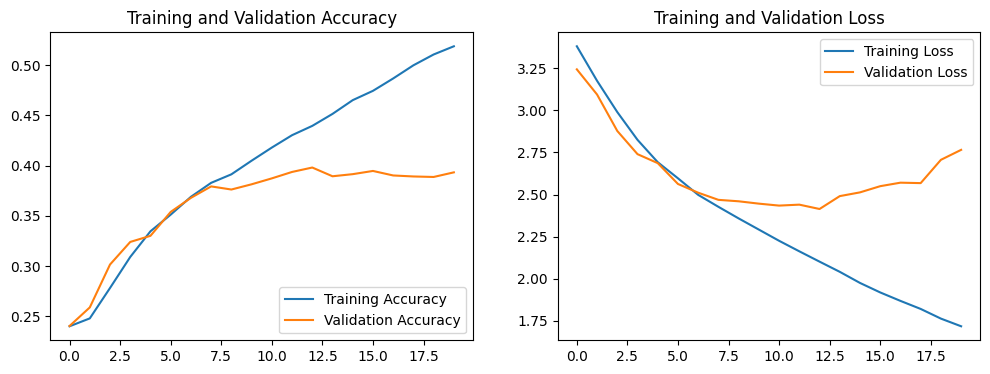

In [8]:
import matplotlib.pyplot as plt
# 5. VISUALIZACIÓN DE GRÁFICAS (Loss y Accuracy)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Gráfica de Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Gráfica de Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


--- Probando predicciones en 5 imágenes aleatorias de validación ---


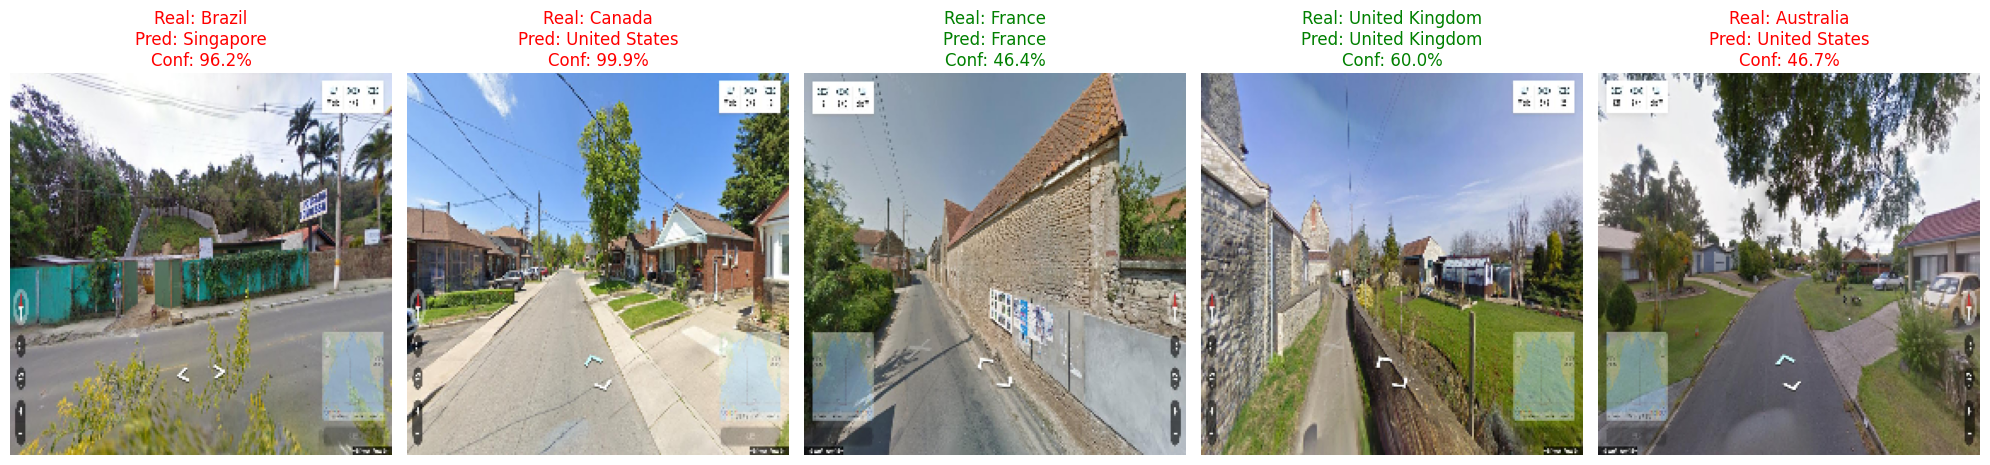

In [9]:
# 6. PRUEBA CON 5 IMÁGENES AL AZAR
print("\n--- Probando predicciones en 5 imágenes aleatorias de validación ---")

# Obtenemos un mapeo inverso de índices a nombres de países (ej: 0 -> 'Spain')
labels_map = {v: k for k, v in train_images.class_indices.items()}

# Sacamos un lote de imágenes del generador de validación
# next() nos devuelve (imágenes, etiquetas_reales)
sample_images, sample_labels = next(val_images)

# Elegimos 5 índices al azar dentro de este lote (el lote suele ser de 32)
random_indices = np.random.choice(range(len(sample_images)), size=5, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    image = sample_images[idx]
    true_label_idx = np.argmax(sample_labels[idx])
    true_country = labels_map[true_label_idx]
    
    # Hacemos la predicción (añadimos dimensión de batch con expand_dims)
    prediction_scores = model.predict(np.expand_dims(image, axis=0), verbose=0)
    predicted_label_idx = np.argmax(prediction_scores)
    predicted_country = labels_map[predicted_label_idx]
    confidence = np.max(prediction_scores) * 100
    
    # Mostramos la imagen
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    
    # Color del título: Verde si acierta, Rojo si falla
    color = 'green' if true_country == predicted_country else 'red'
    
    plt.title(f"Real: {true_country}\nPred: {predicted_country}\nConf: {confidence:.1f}%", 
              color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()